# Playoff Predictor: Using a Neural Network to Forecast Goals per Game in the NHL Postseason

This project began out of curiosity as opposed to any desire for a formal investigation. Along the way, it grew into something that I felt deserved slightly more exposition, so this is the result. 

With the upsurgence of sports betting sponsorships in professional sports leagues also comes an upsurgence in the ridiculousness of welcome offers that sports betting sites are willing to give. With offers ranging from doubling, to quadrupling your first deposit, it's never been a better time to wager with other people's money. My goal here is not necessarily to make money. I know that, in spite of my best efforts, the odds will not be in my favour (the house always wins, so to speak). My goal in betting is to stretch out those free plays for as long as possible. 

While I began (as I think most betters do) by trying to pick the winner of each game, my attention was quickly drawn to the props (bets not tied to the final outcome). The average number of goals scored per game varies from season to season, but in 2023 it was the highest it's been in 30-years; almost 6.5. Off the top of my head, I would have said that 70% of games probably end with 5-8 total goals scored, which made the 4.5:1, 8:1, 4.5:1, and 10:1 odds being offered on 5, 6, 7, and 8 total goals seem very attractive. As a prudent data scientist, however, I wanted to check my assumptions before acting on them. 

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import (metrics, neural_network, preprocessing, pipeline)
from sklearn.model_selection import cross_val_score
import patsy

NHL game data obtained from https://www.hockey-reference.com/leagues/

First, how many games this season actually ended with 5, 6, 7, or 8 total goals? 

In [311]:
nhl_2022_reg = pd.read_csv('nhl2022_reg.csv').set_index("Date")
nhl_2022_reg['total_goals'] = nhl_2022_reg['G'] + nhl_2022_reg['G.1']
percent_values = nhl_2022_reg['total_goals'].value_counts() / sum(nhl_2022_reg['total_goals'].value_counts())
print(percent_values)

7     0.215701
5     0.214177
9     0.111280
6     0.109756
3     0.098323
8     0.087652
4     0.071646
11    0.031250
10    0.026677
1     0.009909
13    0.008384
2     0.008384
12    0.004573
14    0.001524
17    0.000762
Name: total_goals, dtype: float64


So the sum of 5, 6, 7, and 8 goal games is lower than I expected. But this is data from the regular season. It also begs the question of whether or not that's representative of what happens in the playoffs. 

It's commonly thought that scoring decreases in the playoffs (teams play more conservatively with more on the line, refs call less penalties for fear of influencing the outcome...). But again, that assumption is easy enough to validate. 

I'll want to check the average scoring, but also the distribution of goals if that's what I'm going to be betting on. 

In [22]:
def regular_season_vs_playoff_scoring(reg_season_csv, playoff_csv, year):
    """
    Plot regular season vs playoff gpg data for a given season. 
    
    Generates two plots stacked vertically, one for the average gpg, and the other for the distribution.
    """
    
    def import_and_get_metrics(reg_season_csv, playoff_csv):
        
        nhl_reg = pd.read_csv(reg_season_csv).set_index("Date")
        nhl_plf = pd.read_csv(playoff_csv).set_index("Date")
        nhl_reg["total_goals"] = nhl_reg["G"] + nhl_reg["G.1"]
        nhl_plf["total_goals"] = nhl_plf["G"] + nhl_plf["G.1"]
        
        return nhl_reg, nhl_plf
    
    nhl_reg, nhl_plf = import_and_get_metrics(reg_season_csv, playoff_csv)
    
    def plot_gpg_averages(nhl_reg, nhl_plf, year):
    
        #get metrics
        reg_mean = nhl_reg["total_goals"].mean()
        reg_std = nhl_reg["total_goals"].std()
        plf_mean = nhl_plf["total_goals"].mean()
        plf_std = nhl_plf["total_goals"].std()

        #plot gpg average
        fig, ax = plt.subplots(2, figsize=(12,12))
        ax[0].bar(x='Regular Season', height=reg_mean, yerr=reg_std)
        ax[0].bar(x='Playoff', height=plf_mean, yerr=plf_std)
        ax[0].text('Regular Season', reg_mean + 0.1, f'{reg_mean:.2f}', ha='right', va='bottom')
        ax[0].text('Playoff', plf_mean + 0.1, f'{plf_mean:.2f}', ha='right', va='bottom')
        ax[0].set_ylabel('Average goals per game')
        ax[0].set_title(f'{year} Playoff vs Regular Season Average GPG')
    
    plot_gpg_averages(nhl_reg, nhl_plf, year)
    
    def plot_gpg_distribution(nhl_reg, nhl_plf, year):
        
        #get metrics
        reg_vals = nhl_reg['total_goals'].value_counts().sort_index()/len(nhl_reg['total_goals'])
        plf_vals = nhl_plf['total_goals'].value_counts().sort_index()/len(nhl_plf['total_goals'])

        #plot gpg distribution
        ax[1].bar(x = reg_vals.index-0.2, height=reg_vals.values, label='Regular Season', width=0.4)
        ax[1].bar(x = plf_vals.index+0.2, height=plf_vals.values, label='Playoffs', width=0.4)
        diff_thresh = 0.03 #
        for i, (reg_val, plf_val) in enumerate(zip(reg_vals.values, plf_vals.values)):
            diff = plf_val - reg_val
            if abs(diff) > diff_thresh:
                ax[1].annotate('*', xy=(i+1, 0.001), ha='center', weight='bold', fontsize=18)
        ax[1].set_xticks(range(1,max(nhl_reg['total_goals'].max(), nhl_plf['total_goals'].max())+1))
        ax[1].set_xlabel('Goals Per Game')
        ax[1].set_ylabel('Percentage of Games')
        ax[1].set_title(f'{year} Playoff vs Regular Season Goals Per Game Distribution')
        ax[1].legend()
        ax[1].annotate("* indicates a > 3% difference", xy=(0.77,0.8), xycoords='axes fraction', ha='left', va='top')
        
    plot_gpg_distribution(nhl_reg, nhl_plf, year)

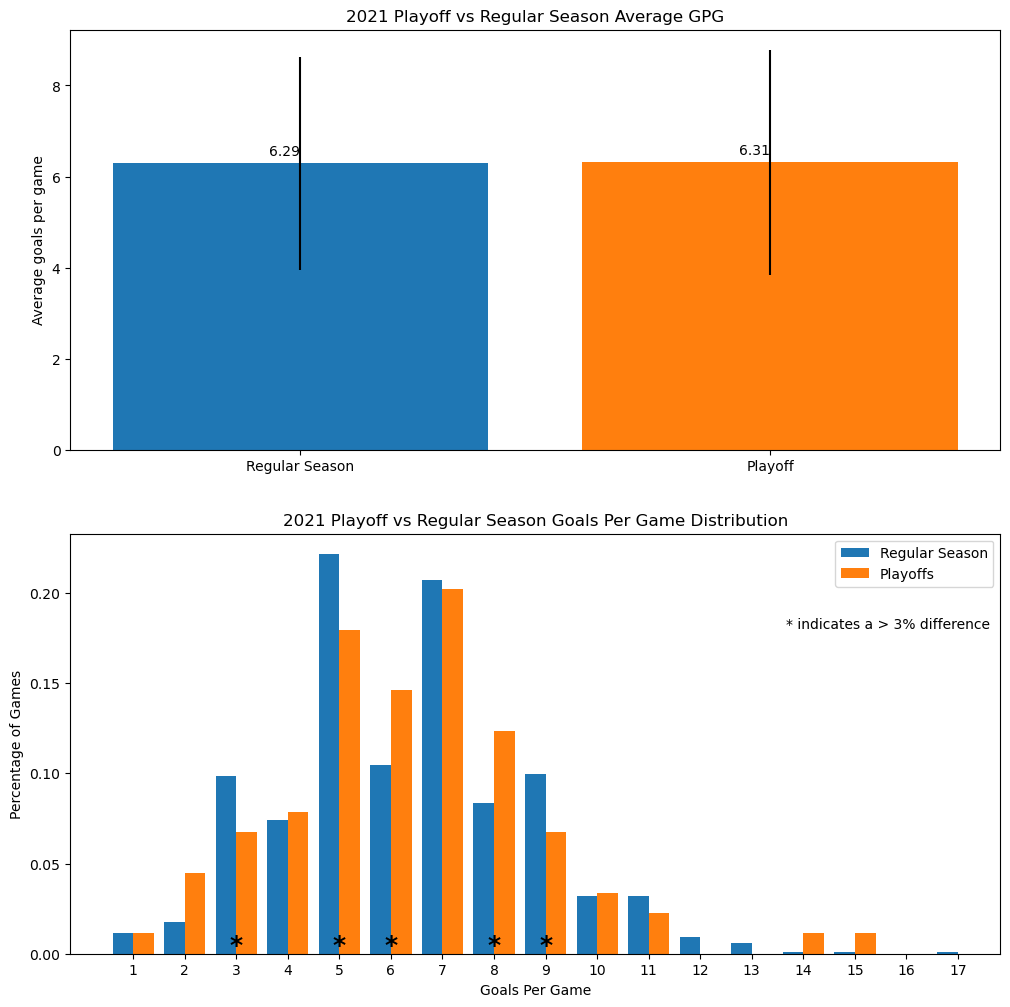

In [23]:
regular_season_vs_playoff_scoring('nhl2021_reg.csv', 'nhl2021_plf.csv', 2021)

In 2021, mean gpg in the regular season vs playoffs are approximately equal. 

The regular season had more 3, 5, and 9 goal games, whereas the playoffs had more 6 and 8 goal games. All other goal totals were approximately equal. 

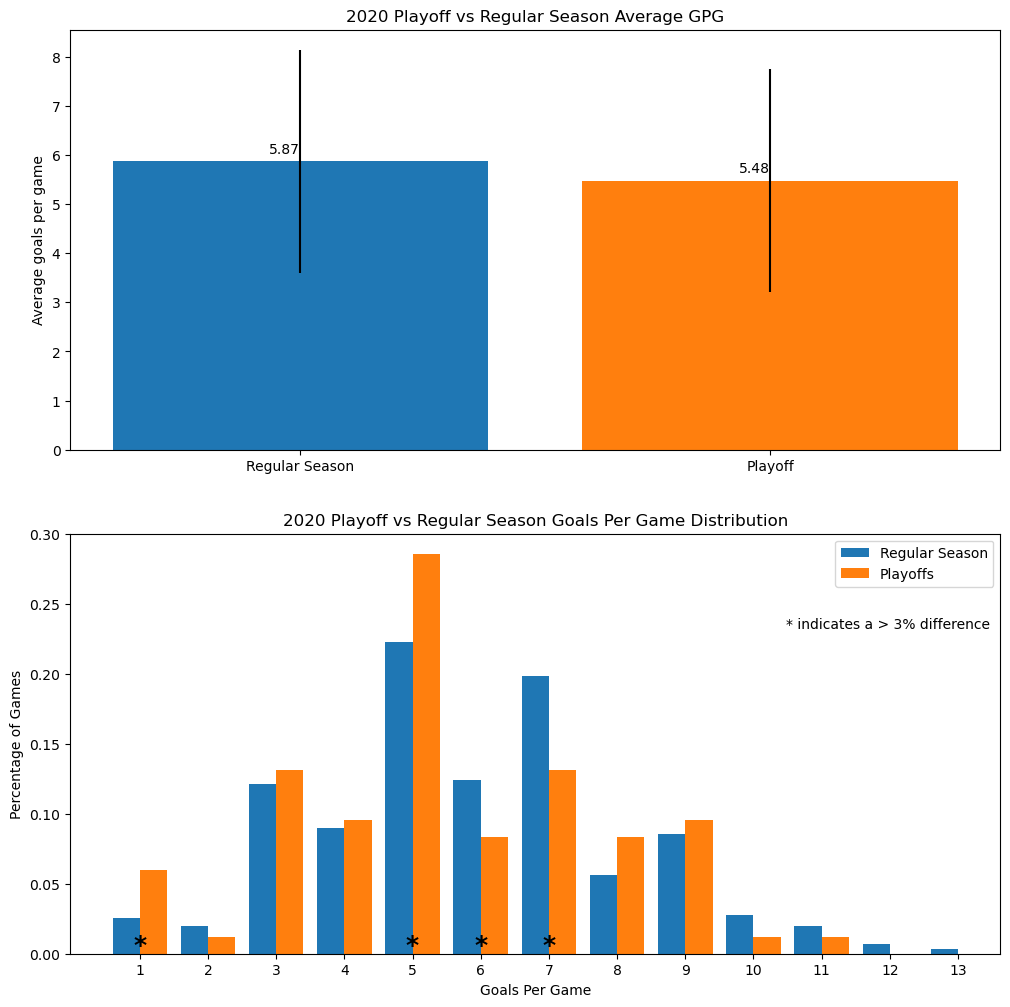

In [24]:
regular_season_vs_playoff_scoring('nhl2020_reg.csv', 'nhl2020_plf.csv', 2020)

In 2020, the playoffs had slightly lower scoring than the regular season (a difference of ~0.4gpg).

The regular season had more 6 and 7 goal games, while the playoffs had more 1 and 5 goal games. 

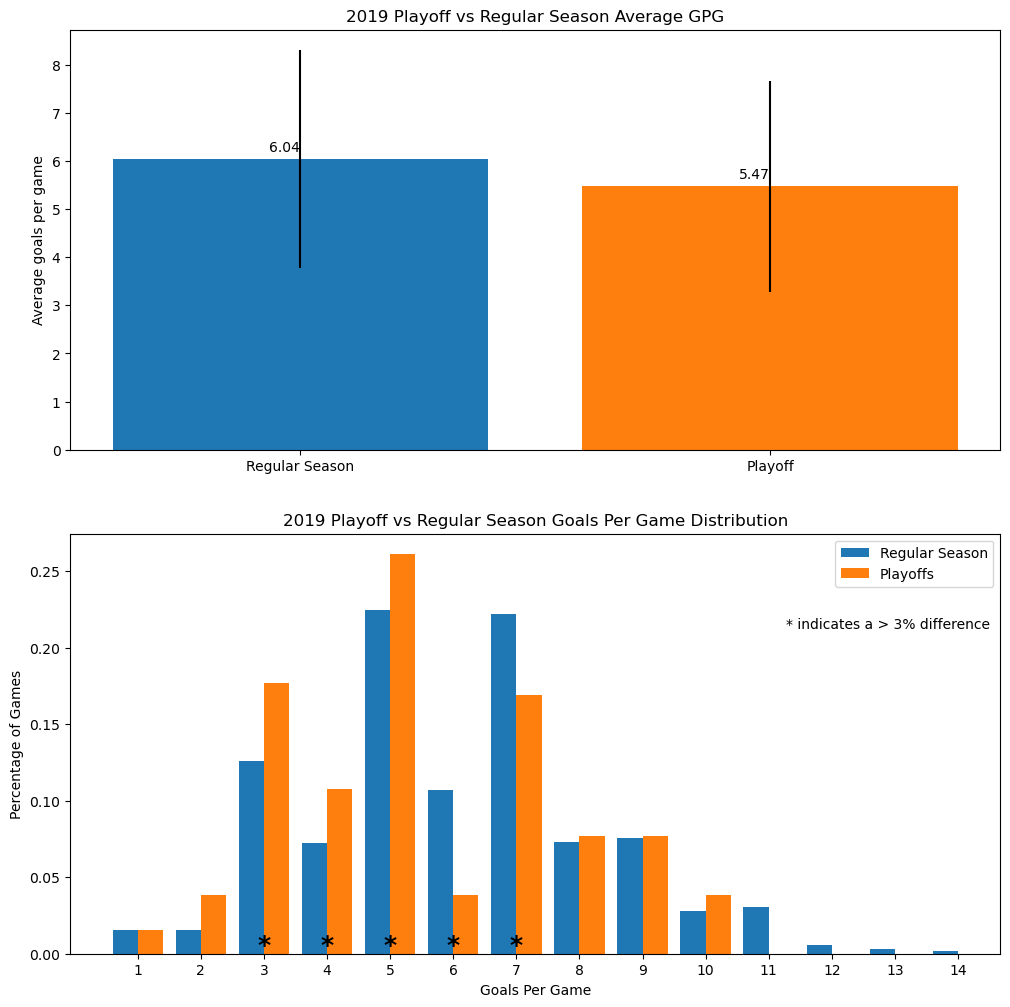

In [25]:
regular_season_vs_playoff_scoring('nhl2019_reg.csv', 'nhl2019_plf.csv', 2019)

In 2019, the playoffs had lower scoring than the regular season (a difference of ~0.6gpg).

The regular season had more 6 and 7 goal games, while the playoffs had more 3, 4, and 5 goal games. 

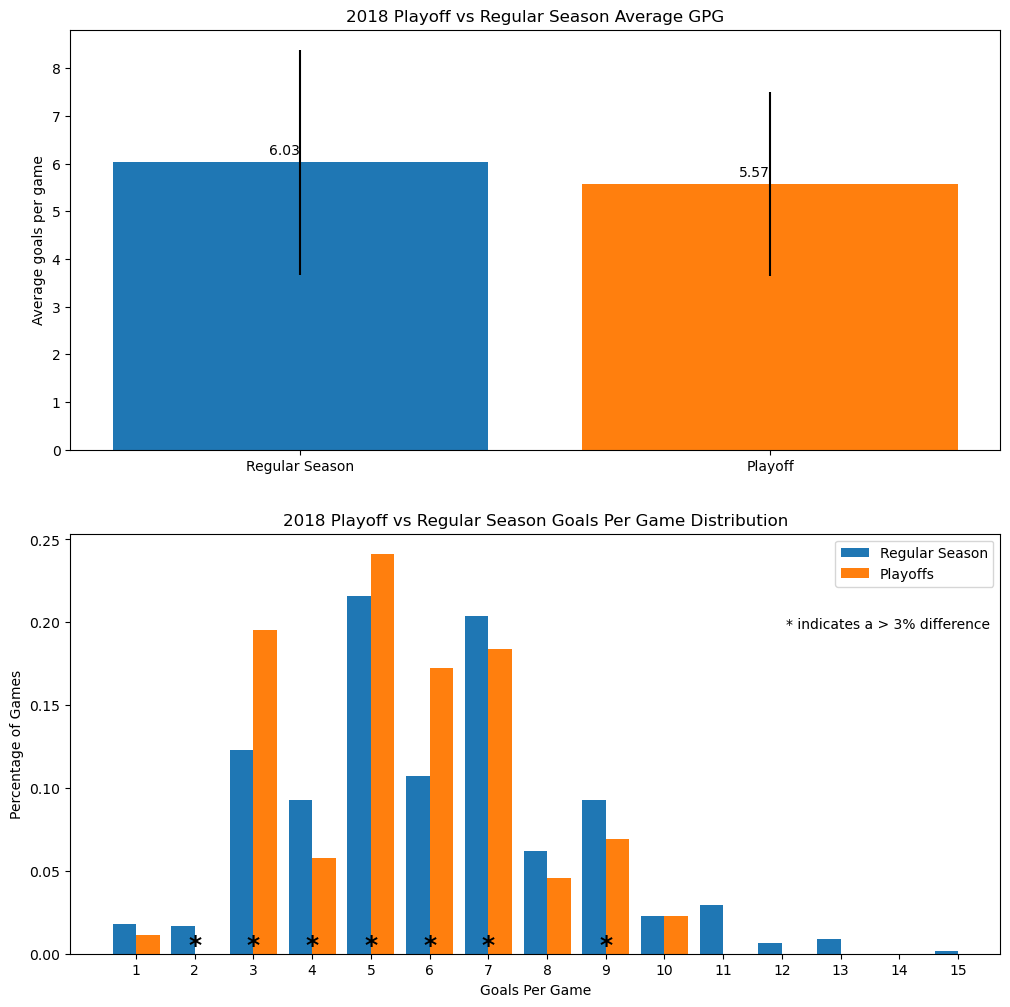

In [26]:
regular_season_vs_playoff_scoring('nhl2018_reg.csv', 'nhl2018_plf.csv', 2018)

In 2018, the playoffs had lower scoring than the regular season (a difference of ~0.5gpg).

The regular season had more 2, 4, 7, and 9 goal games, while the playoffs had more 3, 5, and 6 goal games. 

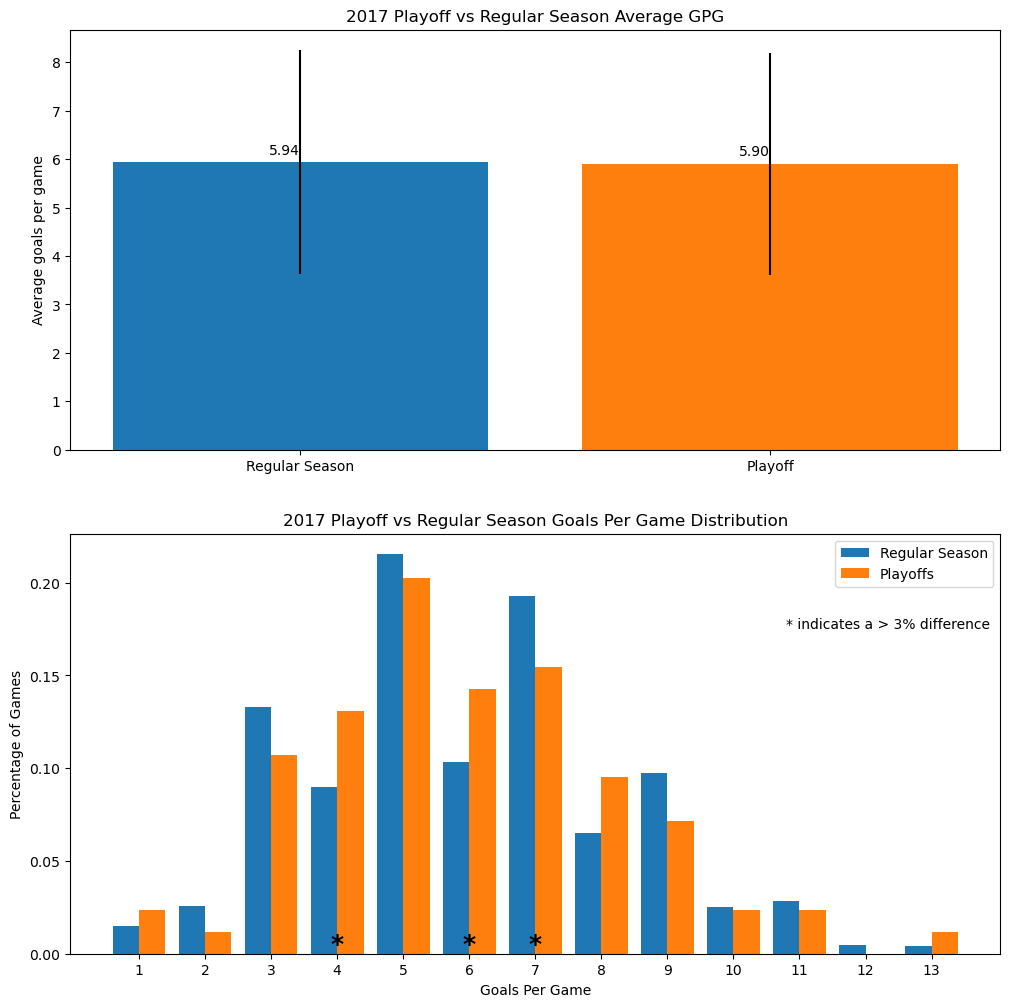

In [27]:
regular_season_vs_playoff_scoring('nhl2017_reg.csv', 'nhl2017_plf.csv', 2017)

In 2017, mean gpg in the regular season vs playoffs are approximately equal. 

The regular season had more 7 goal games, while the playoffs had more 4 and 6 goal games. 

Overall, in the past 5 years the difference between playoff and regular season scoring has been negligible in two years, and there was lower playoff scoring by around 0.5gpg in the other three. 

The the regular season had 3% more 7-goal games in 4/5 years. There is no conclusive trend in the frequency of other gpg values. 

It's not overwhelmingly conclusive that playoff scoring differs from the regular season. Sample size likely plays a role in the differences, but I don't see an obvious scaling factor that can be applied to regular season scoring in order to relate it to playoff scoring. 

## Modelling on this year's data

If I can't simply scale this year's regular season scoring to predict this year's playoff scoring, maybe I can create a model that can. 

I decided to use the past 5 seasons of regular season and playoff data to train a neural network to predict the number of total goals. Based on the results above, I decided it would be wise to add a boolean column representing whether the game was a playoff game or not. 

In [28]:
nhl_2022_reg = pd.read_csv('nhl2022_reg.csv').set_index("Date")
nhl_2021_reg = pd.read_csv('nhl2021_reg.csv').set_index("Date")
nhl_2020_reg = pd.read_csv('nhl2020_reg.csv').set_index("Date")
nhl_2019_reg = pd.read_csv('nhl2019_reg.csv').set_index("Date")
nhl_2018_reg = pd.read_csv('nhl2018_reg.csv').set_index("Date")
nhl_2017_reg = pd.read_csv('nhl2017_reg.csv').set_index("Date")

regs = [nhl_2022_reg, nhl_2021_reg, nhl_2020_reg, nhl_2019_reg, nhl_2018_reg, nhl_2017_reg]

nhl_2021_plf = pd.read_csv('nhl2021_plf.csv').set_index("Date")
nhl_2020_plf = pd.read_csv('nhl2020_plf.csv').set_index("Date")
nhl_2019_plf = pd.read_csv('nhl2019_plf.csv').set_index("Date")
nhl_2018_plf = pd.read_csv('nhl2018_plf.csv').set_index("Date")
nhl_2017_plf = pd.read_csv('nhl2017_plf.csv').set_index("Date")

plfs = [nhl_2021_plf, nhl_2020_plf, nhl_2019_plf, nhl_2018_plf, nhl_2017_plf]

nhl_full = pd.DataFrame()

for dataset in regs:
    dataset['playoffs'] = False
    nhl_full = pd.concat([nhl_full, dataset])

for dataset in plfs:
    dataset['playoffs'] = True
    nhl_full = pd.concat([nhl_full, dataset])
    
nhl_full = nhl_full.drop(columns=["Att.", "Notes"])
nhl_full

,Visitor,G,Home,G.1,Unnamed: 5,LOG,playoffs
Date,,,,,,,
2022-10-07,San Jose Sharks,1,Nashville Predators,4,NaN,2:43,False
2022-10-08,Nashville Predators,3,San Jose Sharks,2,NaN,2:33,False
2022-10-11,Vegas Golden Knights,4,Los Angeles Kings,3,NaN,2:31,False
2022-10-11,Tampa Bay Lightning,1,New York Rangers,3,NaN,2:21,False
2022-10-12,Seattle Kraken,4,Anaheim Ducks,5,OT,2:28,False
...,...,...,...,...,...,...,...
2018-05-28,Washington Capitals,4,Vegas Golden Knights,6,NaN,2:45,True
2018-05-30,Washington Capitals,3,Vegas Golden Knights,2,NaN,2:42,True
2018-06-02,Vegas Golden Knights,1,Washington Capitals,3,NaN,2:38,True


In [29]:
nhl_full['total_goals'] = nhl_full["G"] + nhl_full["G.1"]
nhl_full = nhl_full.reset_index()

#converting the dates to seconds avoids some problems with the NN down the line
nhl_full['Date'] = pd.to_datetime(nhl_full['Date'])
nhl_full["Timestamp"] = nhl_full["Date"].astype(np.int64)/10**9
nhl_full = nhl_full.drop(columns=["Date"])
nhl_full

,Visitor,G,Home,G.1,Unnamed: 5,LOG,playoffs,total_goals,Timestamp
0,San Jose Sharks,1,Nashville Predators,4,NaN,2:43,False,5,1.665101e+09
1,Nashville Predators,3,San Jose Sharks,2,NaN,2:33,False,5,1.665187e+09
2,Vegas Golden Knights,4,Los Angeles Kings,3,NaN,2:31,False,7,1.665446e+09
3,Tampa Bay Lightning,1,New York Rangers,3,NaN,2:21,False,4,1.665446e+09
4,Seattle Kraken,4,Anaheim Ducks,5,OT,2:28,False,9,1.665533e+09
...,...,...,...,...,...,...,...,...,...
7585,Washington Capitals,4,Vegas Golden Knights,6,NaN,2:45,True,10,1.527466e+09
7586,Washington Capitals,3,Vegas Golden Knights,2,NaN,2:42,True,5,1.527638e+09
7587,Vegas Golden Knights,1,Washington Capitals,3,NaN,2:38,True,4,1.527898e+09
7588,Vegas Golden Knights,2,Washington Capitals,6,NaN,2:39,True,8,1.528070e+09


In [30]:
#drop columns with information not available before the game is played
nhl_subset = nhl_full.drop(columns=["G", "G.1", "Unnamed: 5", "LOG"])
nhl_subset

,Visitor,Home,playoffs,total_goals,Timestamp
0,San Jose Sharks,Nashville Predators,False,5,1.665101e+09
1,Nashville Predators,San Jose Sharks,False,5,1.665187e+09
2,Vegas Golden Knights,Los Angeles Kings,False,7,1.665446e+09
3,Tampa Bay Lightning,New York Rangers,False,4,1.665446e+09
4,Seattle Kraken,Anaheim Ducks,False,9,1.665533e+09
...,...,...,...,...,...
7585,Washington Capitals,Vegas Golden Knights,True,10,1.527466e+09
7586,Washington Capitals,Vegas Golden Knights,True,5,1.527638e+09
7587,Vegas Golden Knights,Washington Capitals,True,4,1.527898e+09
7588,Vegas Golden Knights,Washington Capitals,True,8,1.528070e+09


Ideally, there's a lot more data that could be included here. In particular, each team's lineup could have a huge impact on the accuracy of the model. Edmonton with and without Connor McDavid are probably likely to score a different number of goals, for example. Likewise, Tampa Bay with and without Andrei Vasilevskiy will probably concede a different number. 

Other considerations include the availability of playoff data for each team. 2023 marks the playoff debut for the Seattle Kraken, the NHL's newest franchise. How does their playoff scoring compare to the regular season? 

Initial testing did not favour adding interactive parameters to the patsy dmatrices (ie., Timestamp\*C(Home)), so they've been excluded here. It is another thing that could be considered again, however. 

What made this different from any neural network I'd set up before was that I didn't want a single output value. I want to know how confident the model is in its predictions. It would be much more valuable if the model could return a probability distribution for each number of goals scored. Those probabilities can be used alongside the betting odds to determine if I'm likely to make or lose money on average. 

I want to stress that no model can reliably and consistently predict the number of goals scored in each game. There are simply too many variables and unpredictable factors that come into play, and attempting to accurately predict every outcome would be impossible. In fact, this unpredictability is the entire reason why sports are exciting. However, while it may not be possible to achieve perfect accuracy, my goal is to use the available data to swing the odds as much in my favour as possible. The key is to approach the problem with a realistic understanding of the limitations of any predictive model and to focus on maximizing the odds of success rather than achieving perfection.

I chose to do a gid search to optimize hyperparameters. Initial testing showed that lower complexity models (fewer layers and neurons) were performing better on this dataset, so I figured a grid search would not be too expensive. 

In [306]:
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from keras.regularizers import l2
from sklearn.preprocessing import StandardScaler
from keras.optimizers import SGD

def create_model(epochs, optimizer, hidden_layers, l2_penalty, layer1_neurons, layer2_neurons, activation):
    y, X = patsy.dmatrices("total_goals ~ Timestamp + C(Visitor) + C(Home) + C(playoffs)", 
                   nhl_subset, return_type='matrix')
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    model = Sequential()
    model.add(Dense(layer1_neurons, input_dim=X.shape[1], activation=activation))
    for i in range(hidden_layers):
        model.add(Dense(layer2_neurons, activation=activation, bias_regularizer=l2(l2_penalty)))
    model.add(Dense(np.max(y)+1, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=["accuracy"])
    model.fit(X_scaled, keras.utils.to_categorical(y), epochs=epochs, batch_size=32, verbose=0)

    return model

param_grid = {
    'optimizer': ['sgd', 'adam'],
    'epochs': [10, 20, 30],
    'batch_size': [16, 32, 64],
    'hidden_layers': [1, 2, 3],
    'l2_penalty': [0.01, 0.1, 1.0],
    'layer1_neurons': [5, 10, 15],
    'layer2_neurons': [5, 10, 15],
    'activation': ['relu', 'sigmoid', 'tanh']
}

model = KerasClassifier(build_fn=create_model)

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3)
grid_search.fit(X_scaled, keras.utils.to_categorical(y), verbose=0)



/var/folders/7c/glh90ckd7bdfn7cc0xbs4hgr0000gn/T/ipykernel_88239/350498651.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_model)


159/159 [==============================] - 1s 1ms/step - loss: 2.1964 - accuracy: 0.2169


159/159 [==============================] - 0s 1ms/step - loss: 2.1946 - accuracy: 0.2206


159/159 [==============================] - 0s 1ms/step - loss: 2.1909 - accuracy: 0.2233


159/159 [==============================] - 0s 1ms/step - loss: 2.2348 - accuracy: 0.2240


159/159 [==============================] - 0s 1ms/step - loss: 2.1838 - accuracy: 0.2324


159/159 [==============================] - 0s 1ms/step - loss: 2.2078 - accuracy: 0.2233


159/159 [==============================] - 0s 1ms/step - loss: 2.1805 - accuracy: 0.2233


159/159 [==============================] - 0s 1ms/step - loss: 2.2211 - accuracy: 0.2032


80/80 [==============================] - 0s 1ms/step - loss: 2.1929 - accuracy: 0.2273


80/80 [==============================] - 0s 1ms/step - loss: 2.1790 - accuracy: 0.2194


80/80 [==============================] - 0s 1ms/step - loss: 2.1716 - accuracy: 0.2445


80/80 [==============================] - 0s 1ms/step - loss: 2.1892 - accuracy: 0.2308


80/80 [==============================] - 0s 1ms/step - loss: 2.1729 - accuracy: 0.2147


80/80 [==============================] - 0s 1ms/step - loss: 2.2110 - accuracy: 0.2146


80/80 [==============================] - 0s 1ms/step - loss: 2.2199 - accuracy: 0.2225


80/80 [==============================] - 0s 1ms/step - loss: 2.1808 - accuracy: 0.2103


40/40 [==============================] - 0s 1ms/step - loss: 2.1771 - accuracy: 0.2382


40/40 [==============================] - 0s 1ms/step - loss: 2.1781 - accuracy: 0.2178


40/40 [==============================] - 0s 1ms/step - loss: 2.1706 - accuracy: 0.2253


40/40 [==============================] - 0s 1ms/step - loss: 2.1898 - accuracy: 0.2193


40/40 [==============================] - 0s 1ms/step - loss: 2.1720 - accuracy: 0.2284


40/40 [==============================] - 0s 1ms/step - loss: 2.1939 - accuracy: 0.2150


40/40 [==============================] - 0s 1ms/step - loss: 2.1727 - accuracy: 0.2261


159/159 [==============================] - 0s 1ms/step - loss: 2.1690 - accuracy: 0.2351


159/159 [==============================] - 0s 1ms/step - loss: 2.1927 - accuracy: 0.2170


159/159 [==============================] - 0s 1ms/step - loss: 2.1901 - accuracy: 0.2181


159/159 [==============================] - 0s 1ms/step - loss: 2.1892 - accuracy: 0.2264


159/159 [==============================] - 0s 931us/step - loss: 2.1766 - accuracy: 0.2233


159/159 [==============================] - 0s 1ms/step - loss: 2.1769 - accuracy: 0.2233


159/159 [==============================] - 0s 1ms/step - loss: 2.1892 - accuracy: 0.2232


159/159 [==============================] - 0s 1ms/step - loss: 2.1698 - accuracy: 0.2162


159/159 [==============================] - 0s 944us/step - loss: 2.1857 - accuracy: 0.2181


80/80 [==============================] - 0s 955us/step - loss: 2.1815 - accuracy: 0.2272


80/80 [==============================] - 0s 1ms/step - loss: 2.1800 - accuracy: 0.2233


80/80 [==============================] - 0s 1ms/step - loss: 2.2003 - accuracy: 0.2170


80/80 [==============================] - 0s 1ms/step - loss: 2.1875 - accuracy: 0.2170


80/80 [==============================] - 0s 1ms/step - loss: 2.1626 - accuracy: 0.2324


80/80 [==============================] - 0s 1ms/step - loss: 2.1860 - accuracy: 0.2181


80/80 [==============================] - 0s 1ms/step - loss: 2.1832 - accuracy: 0.2170


80/80 [==============================] - 0s 1ms/step - loss: 2.1685 - accuracy: 0.2233


40/40 [==============================] - 0s 1ms/step - loss: 2.1939 - accuracy: 0.2181


40/40 [==============================] - 0s 1ms/step - loss: 2.2109 - accuracy: 0.2170


40/40 [==============================] - 0s 2ms/step - loss: 2.1571 - accuracy: 0.2387


40/40 [==============================] - 0s 1ms/step - loss: 2.1954 - accuracy: 0.2181


40/40 [==============================] - 0s 1ms/step - loss: 2.1898 - accuracy: 0.2170


40/40 [==============================] - 0s 1ms/step - loss: 2.1591 - accuracy: 0.2351


40/40 [==============================] - 0s 1ms/step - loss: 2.1864 - accuracy: 0.2181


40/40 [==============================] - 0s 1ms/step - loss: 2.1837 - accuracy: 0.2170


159/159 [==============================] - 0s 1ms/step - loss: 2.2099 - accuracy: 0.2165


159/159 [==============================] - 0s 1ms/step - loss: 2.1871 - accuracy: 0.2147


159/159 [==============================] - 0s 1ms/step - loss: 2.1968 - accuracy: 0.2103


159/159 [==============================] - 0s 1ms/step - loss: 2.1936 - accuracy: 0.2169


159/159 [==============================] - 0s 1ms/step - loss: 2.2326 - accuracy: 0.2253


159/159 [==============================] - 0s 1ms/step - loss: 2.1926 - accuracy: 0.2103


159/159 [==============================] - 0s 1ms/step - loss: 2.1988 - accuracy: 0.2205


80/80 [==============================] - 0s 1ms/step - loss: 2.1817 - accuracy: 0.2158


80/80 [==============================] - 0s 1ms/step - loss: 2.2105 - accuracy: 0.2240


80/80 [==============================] - 0s 1ms/step - loss: 2.2176 - accuracy: 0.2150


80/80 [==============================] - 0s 1ms/step - loss: 2.1833 - accuracy: 0.2182


80/80 [==============================] - 0s 1ms/step - loss: 2.1856 - accuracy: 0.2366


80/80 [==============================] - 0s 1ms/step - loss: 2.1827 - accuracy: 0.2237


80/80 [==============================] - 0s 1ms/step - loss: 2.1905 - accuracy: 0.2320


80/80 [==============================] - 0s 2ms/step - loss: 2.1868 - accuracy: 0.2252


40/40 [==============================] - 0s 1ms/step - loss: 2.2629 - accuracy: 0.2186


40/40 [==============================] - 0s 1ms/step - loss: 2.1621 - accuracy: 0.2403


40/40 [==============================] - 0s 1ms/step - loss: 2.2566 - accuracy: 0.2287


40/40 [==============================] - 0s 1ms/step - loss: 2.1897 - accuracy: 0.2324


40/40 [==============================] - 0s 1ms/step - loss: 2.1755 - accuracy: 0.2386


40/40 [==============================] - 0s 1ms/step - loss: 2.1742 - accuracy: 0.2276


40/40 [==============================] - 0s 1ms/step - loss: 2.1682 - accuracy: 0.2312


40/40 [==============================] - 0s 1ms/step - loss: 2.2055 - accuracy: 0.2244


40/40 [==============================] - 0s 1ms/step - loss: 2.2288 - accuracy: 0.2150


GridSearchCV(cv=3,
             estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x7fedfc08fe20>,
             param_grid={'activation': ['relu', 'sigmoid', 'tanh'],
                         'batch_size': [16, 32, 64], 'epochs': [10, 20, 30],
                         'hidden_layers': [1, 2, 3],
                         'l2_penalty': [0.01, 0.1, 1.0],
                         'layer1_neurons': [5, 10, 15],
                         'layer2_neurons': [5, 10, 15],
                         'optimizer': ['sgd', 'adam']})

In [307]:
print(grid_search.best_params_)
print(grid_search.best_estimator_.model)

{'activation': 'relu', 'batch_size': 64, 'epochs': 20, 'hidden_layers': 1, 'l2_penalty': 0.01, 'layer1_neurons': 15, 'layer2_neurons': 15, 'optimizer': 'sgd'}


With this optimized model, we can see how it performs on available results from the 2023 playoffs (as of April 23rd, 2023). More data can be added as it's available to test the model further. 

In [214]:
early_2023_data = {
    "Date" : ['2023-04-17', '2023-04-17', '2023-04-17', '2023-04-17', 
              '2023-04-18', '2023-04-18', '2023-04-18', '2023-04-18',
              '2023-04-19', '2023-04-19', '2023-04-19', '2023-04-19', 
              '2023-04-20', '2023-04-20', '2023-04-20', '2023-04-20',
              '2023-04-21', '2023-04-21', '2023-04-21', '2023-04-21', 
              '2023-04-22', '2023-04-22', '2023-04-22', '2023-04-22',
              '2023-04-23', '2023-04-23', '2023-04-23', '2023-04-23'], 
    "Visitor" : ['New York Islanders', 'Florida Panthers', 'Minnesota Wild', 'Los Angeles Kings',
                'New York Rangers', 'Tampa Bay Lightning', 'Winnipeg Jets', 'Seattle Kraken',
                'New York Islanders', 'Florida Panthers', 'Minnesota Wild', 'Los Angeles Kings',
                'New York Rangers', 'Tampa Bay Lightning', 'Winnipeg Jets', 'Seattle Kraken',
                'Carolina Hurricanes', 'Boston Bruins', 'Dallas Stars', 'Edmonton Oilers',
                'Vegas Golden Knights', 'Toronto Maple Leafs', 'New Jersey Devils', 'Colorado Avalanche',
                'Carolina Hurricanes', 'Boston Bruins', 'Dallas Stars', 'Edmonton Oilers'],
    "Home" : ['Carolina Hurricanes', 'Boston Bruins', 'Dallas Stars', 'Edmonton Oilers',
             'New Jersey Devils', 'Toronto Maple Leafs', 'Vegas Golden Knights', 'Colorado Avalanche',
             'Carolina Hurricanes', 'Boston Bruins', 'Dallas Stars', 'Edmonton Oilers',
             'New Jersey Devils', 'Toronto Maple Leafs', 'Vegas Golden Knights', 'Colorado Avalanche',
             'New York Islanders', 'Florida Panthers', 'Minnesota Wild', 'Los Angeles Kings',
              'Winnipeg Jets', 'Tampa Bay Lightning', 'New York Rangers', 'Seattle Kraken',
              'New York Islanders', 'Florida Panthers', 'Minnesota Wild', 'Los Angeles Kings'],
    "playoffs" : [True, True, True, True,
                 True, True, True, True,
                 True, True, True, True,
                 True, True, True, True,
                 True, True, True, True,
                 True, True, True, True,
                 True, True, True, True],
    'total_goals' : [3, 4, 5, 7,
                     6, 10, 6, 4,
                     7, 9, 10, 6,
                     9, 6, 5, 7,
                     6, 6, 6, 5,
                     9, 7, 3, 10,
                     7, 8, 5, 9]
}

In [224]:
early_2023_test_data = pd.DataFrame(early_2023_data)
early_2023_test_data["Date"] = pd.to_datetime(early_2023_test_data["Date"])
early_2023_test_data["Timestamp"] = early_2023_test_data["Date"].astype(np.int64)/10**9
early_2023_test_data = early_2023_test_data.drop(columns=["Date"])
early_2023_test_data

,Visitor,Home,playoffs,total_goals,Timestamp
0,New York Islanders,Carolina Hurricanes,True,3,1.681690e+09
1,Florida Panthers,Boston Bruins,True,4,1.681690e+09
2,Minnesota Wild,Dallas Stars,True,5,1.681690e+09
3,Los Angeles Kings,Edmonton Oilers,True,7,1.681690e+09
4,New York Rangers,New Jersey Devils,True,6,1.681776e+09
5,Tampa Bay Lightning,Toronto Maple Leafs,True,10,1.681776e+09
6,Winnipeg Jets,Vegas Golden Knights,True,6,1.681776e+09
7,Seattle Kraken,Colorado Avalanche,True,4,1.681776e+09
8,New York Islanders,Carolina Hurricanes,True,7,1.681862e+09
9,Florida Panthers,Boston Bruins,True,9,1.681862e+09


In [225]:
combined_old_new_data = pd.concat([nhl_subset, early_2023_test_data])
combined_old_new_data.reset_index(drop=True,inplace=True)
combined_old_new_data

,Visitor,Home,playoffs,total_goals,Timestamp
0,San Jose Sharks,Nashville Predators,False,5,1.665101e+09
1,Nashville Predators,San Jose Sharks,False,5,1.665187e+09
2,Vegas Golden Knights,Los Angeles Kings,False,7,1.665446e+09
3,Tampa Bay Lightning,New York Rangers,False,4,1.665446e+09
4,Seattle Kraken,Anaheim Ducks,False,9,1.665533e+09
...,...,...,...,...,...
7613,Colorado Avalanche,Seattle Kraken,True,10,1.682122e+09
7614,Carolina Hurricanes,New York Islanders,True,7,1.682208e+09
7615,Boston Bruins,Florida Panthers,True,8,1.682208e+09
7616,Dallas Stars,Minnesota Wild,True,5,1.682208e+09


In [308]:
def predict_goals(model):
    """
    Test a model with 3 layers of given EPOCHS on available 2023 playoff data.
    Returns an average 5 models per layer size as cross-validation.
    """
#     def create_model():
#         y, X = patsy.dmatrices("total_goals ~ Timestamp + C(Visitor) + C(Home) + C(playoffs)", 
#                        nhl_subset, return_type='matrix')
#         scaler = StandardScaler()
#         X_scaled = scaler.fit_transform(X)

#         model = Sequential()
#         model.add(Dense(5, input_dim=X.shape[1], activation='relu', bias_regularizer=l2(0.01)))
#         model.add(Dense(5, activation='relu', bias_regularizer=l2(0.01)))
#         model.add(Dense(np.max(y)+1, activation='softmax'))

#         model.compile(loss='categorical_crossentropy', optimizer='adam')
#         model.fit(X_scaled, keras.utils.to_categorical(y), epochs=30, batch_size=64, verbose=0)
        
#         return model
    
#     model = grid_search.best_estimator_.model
    
    def predict_goals(model):
        y, X = patsy.dmatrices("total_goals ~ Timestamp + C(Visitor) + C(Home) + C(playoffs)", 
                       combined_old_new_data, return_type='matrix')

        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)

        new_data = X_scaled[-28:,:]

        predicted_goals = model.predict(new_data)
        return predicted_goals 
    
    predicted_goals = predict_goals(model)
    
    def check_accuracy(predicted_goals):
        goals = range(1,19)
        num_correct = 0

        for i in range(len(predicted_goals)):

            preds = predicted_goals[i]
            predictions = dict(zip(goals,preds))
            largest_indices = np.argpartition(preds, -3)[-3:]
            largest_keys = [goals[i] for i in largest_indices]

            actual_goals = early_2023_test_data['total_goals'][i]

            if actual_goals in largest_keys:
                num_correct += 1
                
        return num_correct/len(predicted_goals)*100

        
    acc = check_accuracy(predicted_goals)
    
    print(f"The actual score is within the top 3 estimates {acc}% of the time")
    
    return predicted_goals

In [309]:
predicted_goals = predict_goals(grid_search.best_estimator_.model)
predicted_goals

1/1 [==============================] - 0s 50ms/step
The actual score is within the top 3 estimates 39.285714285714285% of the time


array([[6.03645494e-05, 4.31986293e-03, 1.26994299e-02, 1.93470404e-01,
        4.36968468e-02, 3.28597903e-01, 1.00618213e-01, 2.09319562e-01,
        3.34142782e-02, 4.64536026e-02, 1.53929759e-02, 7.89681077e-03,
        1.24728354e-03, 2.36657052e-03, 1.53641857e-04, 7.49405663e-05,
        1.66582162e-04, 5.05707030e-05],
       [1.31502413e-04, 7.98952114e-03, 1.03479559e-02, 8.65264386e-02,
        7.45332316e-02, 2.20760599e-01, 1.25880033e-01, 2.82590657e-01,
        6.52055293e-02, 6.88830689e-02, 3.69099714e-02, 1.36326170e-02,
        2.40469514e-03, 3.11401021e-03, 3.35520192e-04, 2.35532178e-04,
        2.74401362e-04, 2.44671566e-04],
       [9.60289617e-05, 7.34173367e-03, 1.49673969e-02, 9.57000330e-02,
        8.53289664e-02, 2.49490529e-01, 1.54767513e-01, 1.87297776e-01,
        6.83938935e-02, 7.29908869e-02, 4.13716622e-02, 1.46987839e-02,
        3.48330964e-03, 2.96483515e-03, 4.68378857e-04, 1.45623577e-04,
        2.80241802e-04, 2.12532294e-04],
       [2.009

For the available data, the actual score is within the top 3 estimates 39% of the time. It would also be valuable to visualize the predictions for each game. 

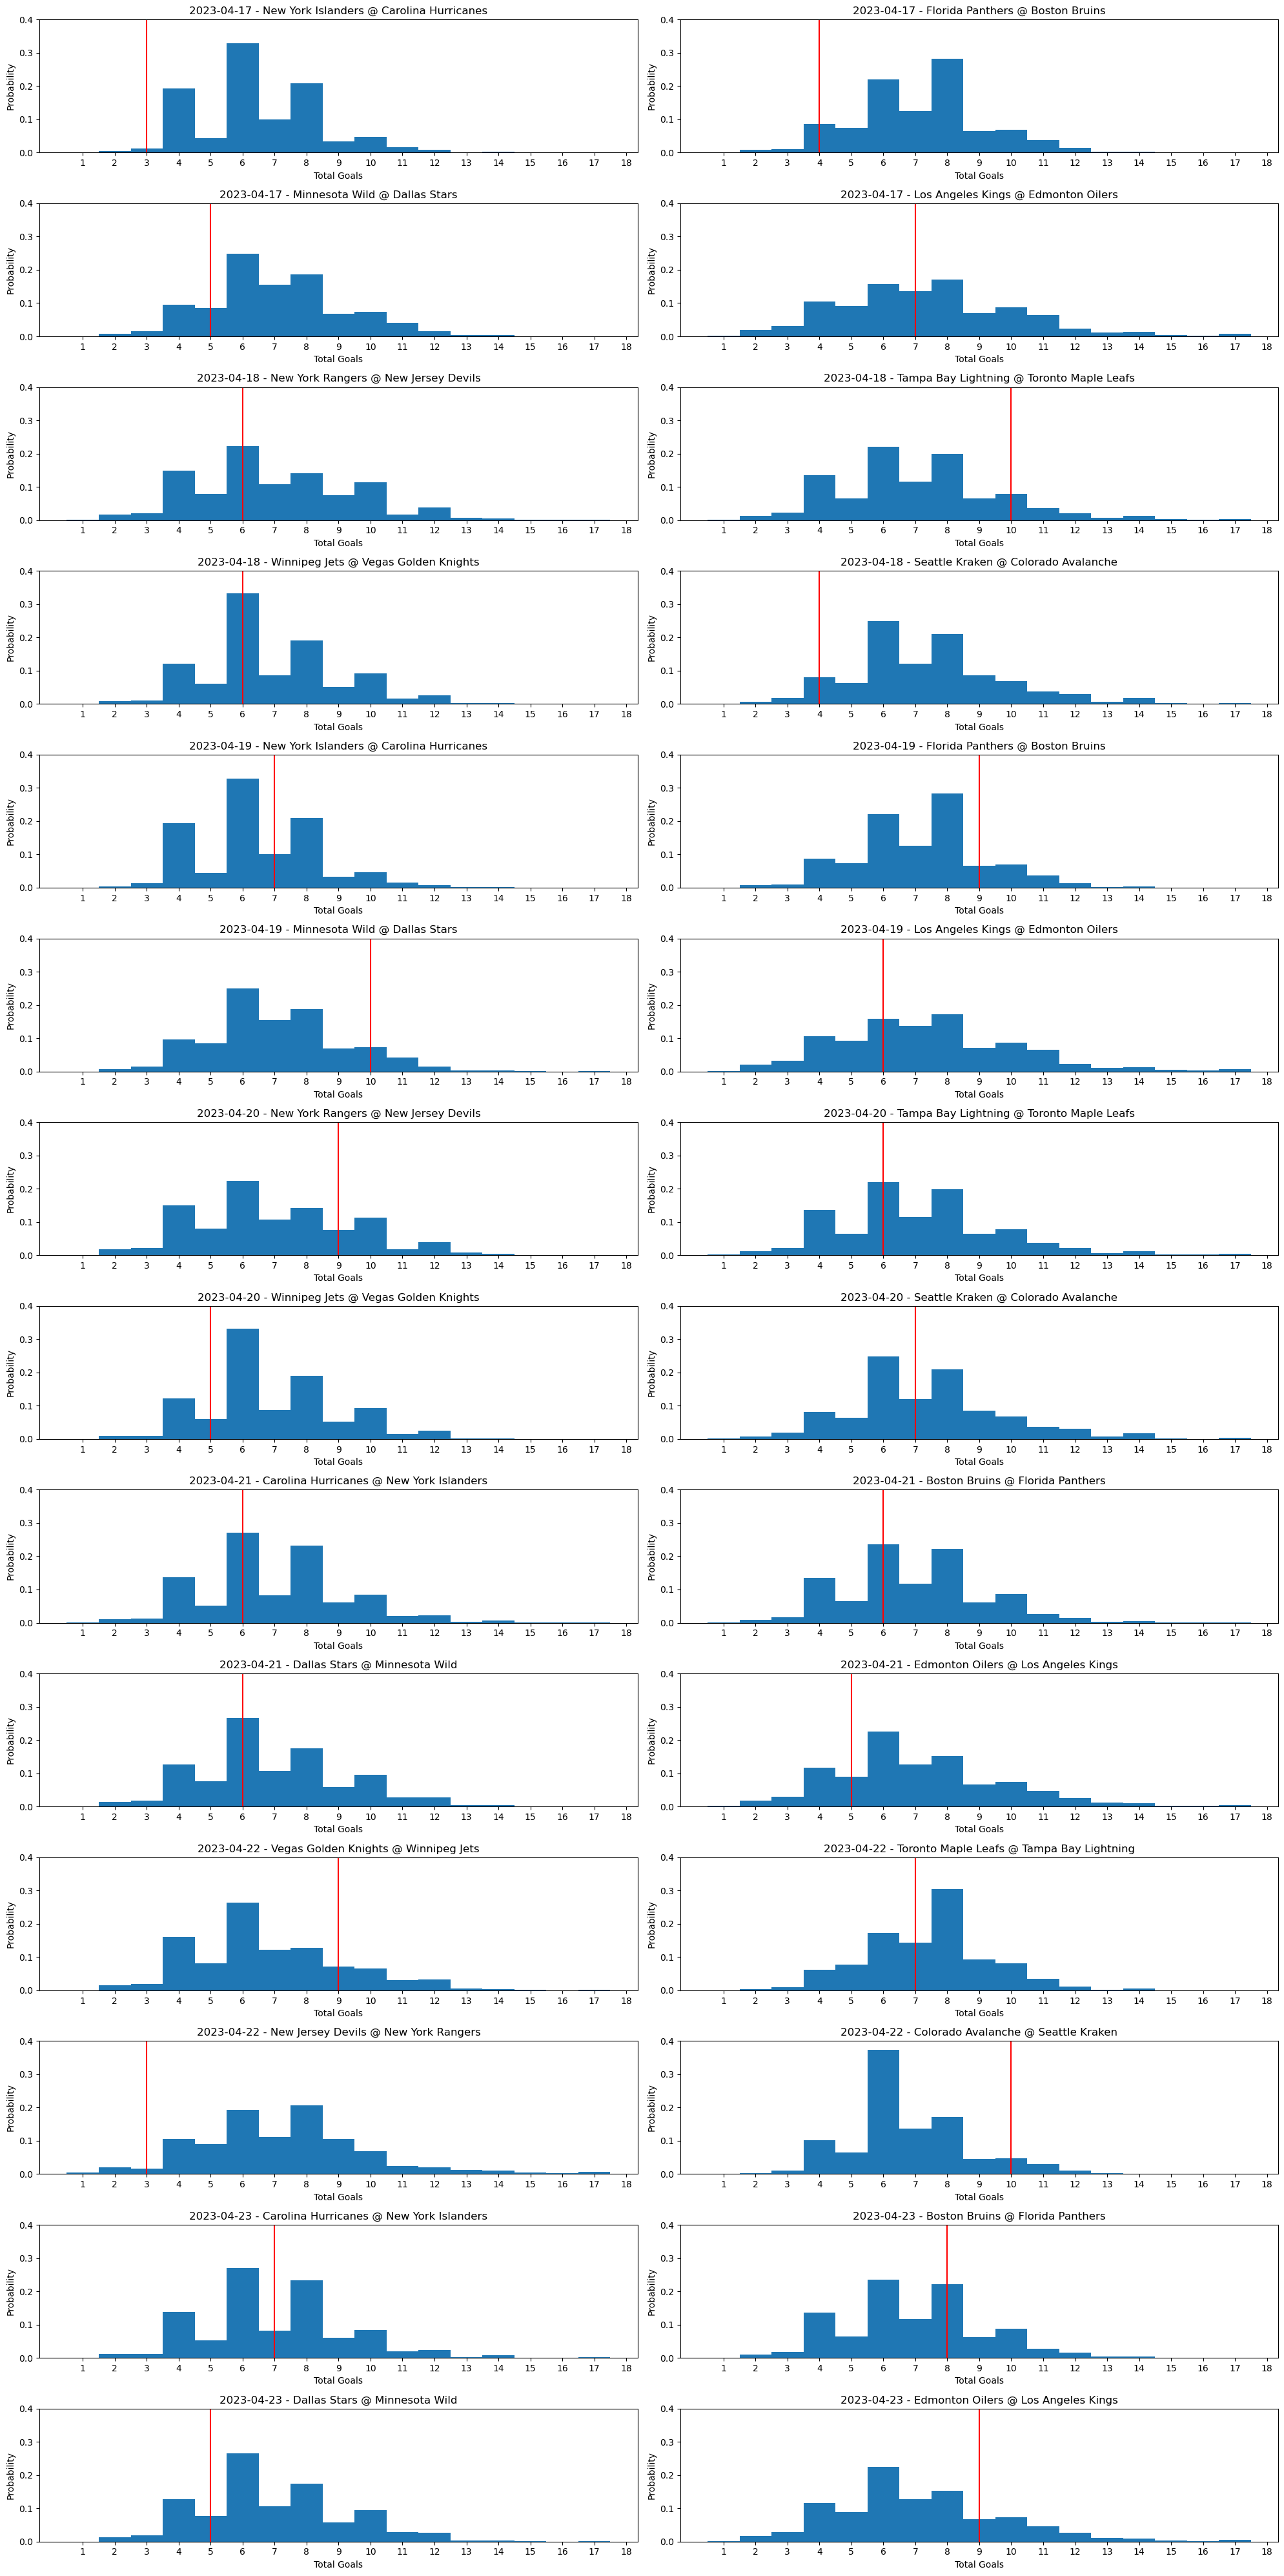

In [314]:
fig, ax = plt.subplots(14,2, figsize=(20,40))

for i in range(len(predicted_goals)):
    goals = range(1,len(predicted_goals[i])+1)
    preds = predicted_goals[i]
    goal_vals = dict(zip(goals, preds))
    
    date = pd.to_datetime(early_2023_test_data['Timestamp'][i], unit='s').strftime('%Y-%m-%d')
    game = f"{date} - {early_2023_test_data['Visitor'][i]} @ {early_2023_test_data['Home'][i]}"
    
    row, col = divmod(i, 2)  
    ax[row, col].hist(list(goal_vals.keys()), bins=goals, weights=list(goal_vals.values()), align='left')
    ax[row, col].axvline(x=early_2023_test_data['total_goals'][i], color='r')
    ax[row, col].set_xticks(goals)
    ax[row,col].set_title(game)
    ax[row,col].set_xlabel('Total Goals')
    ax[row,col].set_ylabel('Probability')
    ax[row,col].set_ylim(0, 0.4)

fig.tight_layout()

Strangely, the model has a strong bias towards predicting 6 or 8 goals being scored - which only occured in 11% and 9% of regular season games respectively, and even numbers from 4 to 12 generally look to be local maxima. 

In [31]:
y, X = patsy.dmatrices("total_goals ~ Timestamp + C(Visitor) + C(Home) + C(playoffs)", 
                       nhl_subset, return_type='matrix')

hidden_layers = [(5,), (10,), (15,), (20,), 
                 (5,5), (10,10), (15,15), (20,20),
                 (5,5,5), (10,10,10), (15,15,15), (20,20,20)]
for hidden_layer in hidden_layers:
    nn_scaled_model = pipeline.make_pipeline(
        preprocessing.StandardScaler(),
        neural_network.MLPRegressor(hidden_layer, max_iter=5000, random_state=123)
    )
    
    scores = cross_val_score(nn_scaled_model, X, y.flatten(), cv=5, scoring='neg_mean_squared_error')
    
    print(f"With a hidden layer of {hidden_layer} the average MSE is: {-scores.mean()}, and the standard deviation of MSE is: {scores.std()}")

With a hidden layer of (5,) the average MSE is: 5.552899879702839, and the standard deviation of MSE is: 0.19246078561253668
With a hidden layer of (10,) the average MSE is: 5.865399270727551, and the standard deviation of MSE is: 0.19683760329895478
With a hidden layer of (15,) the average MSE is: 6.084776426327145, and the standard deviation of MSE is: 0.25671408591708106
With a hidden layer of (20,) the average MSE is: 6.32045754981895, and the standard deviation of MSE is: 0.2909261602793537
With a hidden layer of (5, 5) the average MSE is: 5.5864282161989305, and the standard deviation of MSE is: 0.18051693941416738
With a hidden layer of (10, 10) the average MSE is: 5.897793050596292, and the standard deviation of MSE is: 0.12147450628410168
With a hidden layer of (15, 15) the average MSE is: 6.297284888671004, and the standard deviation of MSE is: 0.2640543897001592
With a hidden layer of (20, 20) the average MSE is: 6.484735989243478, and the standard deviation of MSE is: 0.325

Three hidden layers with (10,10) nodes each seems the best balance between a low MSE and stdev.

In [39]:
y, X = patsy.dmatrices("total_goals ~ Timestamp + C(Visitor) + C(Home) + C(playoffs)", 
                       nhl_subset, return_type='matrix')

best_nn_scaled_model = pipeline.make_pipeline(
        preprocessing.StandardScaler(),
        neural_network.MLPRegressor((10,10,10), max_iter=5000, random_state=123)
    )
 
best_nn_scaled_model.fit(X, y.flatten())

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('mlpregressor',
                 MLPRegressor(hidden_layer_sizes=(10, 10, 10), max_iter=5000,
                              random_state=123))])

In [229]:
from tensorflow import keras
from tensorflow.keras.layers import Dense, Softmax
from tensorflow.keras.models import Sequential

y, X = patsy.dmatrices("total_goals ~ Timestamp + C(Visitor) + C(Home) + C(playoffs)", 
                       nhl_subset, return_type='matrix')
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

model = Sequential()
model.add(Dense(20, input_dim=X.shape[1], activation='relu'))
model.add(Dense(20, activation='relu'))
model.add(Dense(20, activation='relu'))
model.add(Dense(np.max(y)+1, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam')
model.fit(X_scaled, keras.utils.to_categorical(y), epochs=100, batch_size=32)

Epoch 1/100
238/238 [==============================] - 1s 1ms/step - loss: 2.3985
Epoch 2/100
238/238 [==============================] - 0s 1ms/step - loss: 2.2050
Epoch 3/100
238/238 [==============================] - 0s 1ms/step - loss: 2.1758
Epoch 4/100
238/238 [==============================] - 0s 1ms/step - loss: 2.1630
Epoch 5/100
238/238 [==============================] - 0s 1ms/step - loss: 2.1526
Epoch 6/100
238/238 [==============================] - 0s 1ms/step - loss: 2.1454
Epoch 7/100
238/238 [==============================] - 0s 1ms/step - loss: 2.1385
Epoch 8/100
238/238 [==============================] - 0s 1ms/step - loss: 2.1320
Epoch 9/100
238/238 [==============================] - 0s 1ms/step - loss: 2.1252
Epoch 10/100
238/238 [==============================] - 0s 1ms/step - loss: 2.1180
Epoch 11/100
238/238 [==============================] - 0s 1ms/step - loss: 2.1132
Epoch 12/100
238/238 [==============================] - 0s 1ms/step - loss: 2.1070
Epoch 13/100


238/238 [==============================] - 0s 1ms/step - loss: 1.9228
Epoch 100/100
238/238 [==============================] - 0s 1ms/step - loss: 1.9235


In [230]:
y, X = patsy.dmatrices("total_goals ~ Timestamp + C(Visitor) + C(Home) + C(playoffs)", 
                       combined_old_new_data, return_type='matrix')

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

new_data = X_scaled[-28:,:]

predicted_goals = model.predict(new_data)
predicted_goals

1/1 [==============================] - 0s 50ms/step


array([[2.17188027e-31, 3.87845817e-03, 2.75110430e-03, 4.43344414e-02,
        1.35212280e-02, 2.20125198e-01, 9.17015597e-03, 6.30692720e-01,
        6.17316328e-02, 1.26894498e-02, 1.09339471e-03, 1.20049381e-05,
        1.19362696e-07, 6.62510091e-09, 3.80183656e-23, 7.29009477e-14,
        1.59806161e-33, 9.35022040e-27],
       [3.18696835e-16, 2.38351747e-02, 4.15847357e-03, 7.36725405e-02,
        1.60814032e-01, 2.93225676e-01, 2.16738522e-01, 9.31275487e-02,
        6.92602769e-02, 2.69261450e-02, 1.84936207e-02, 1.82640459e-02,
        3.33534932e-04, 1.14724180e-03, 2.67662472e-06, 4.69840899e-07,
        3.42993286e-17, 7.93235366e-10],
       [8.62708038e-09, 8.00753310e-02, 1.08200647e-01, 1.53312519e-01,
        1.24452166e-01, 1.23697639e-01, 1.07661724e-01, 5.31789809e-02,
        7.00466558e-02, 4.11048383e-02, 3.72668467e-02, 3.87070365e-02,
        6.07237173e-03, 1.88337581e-03, 8.59070788e-05, 5.42537086e-02,
        3.68843200e-09, 1.26758067e-07],
       [1.881

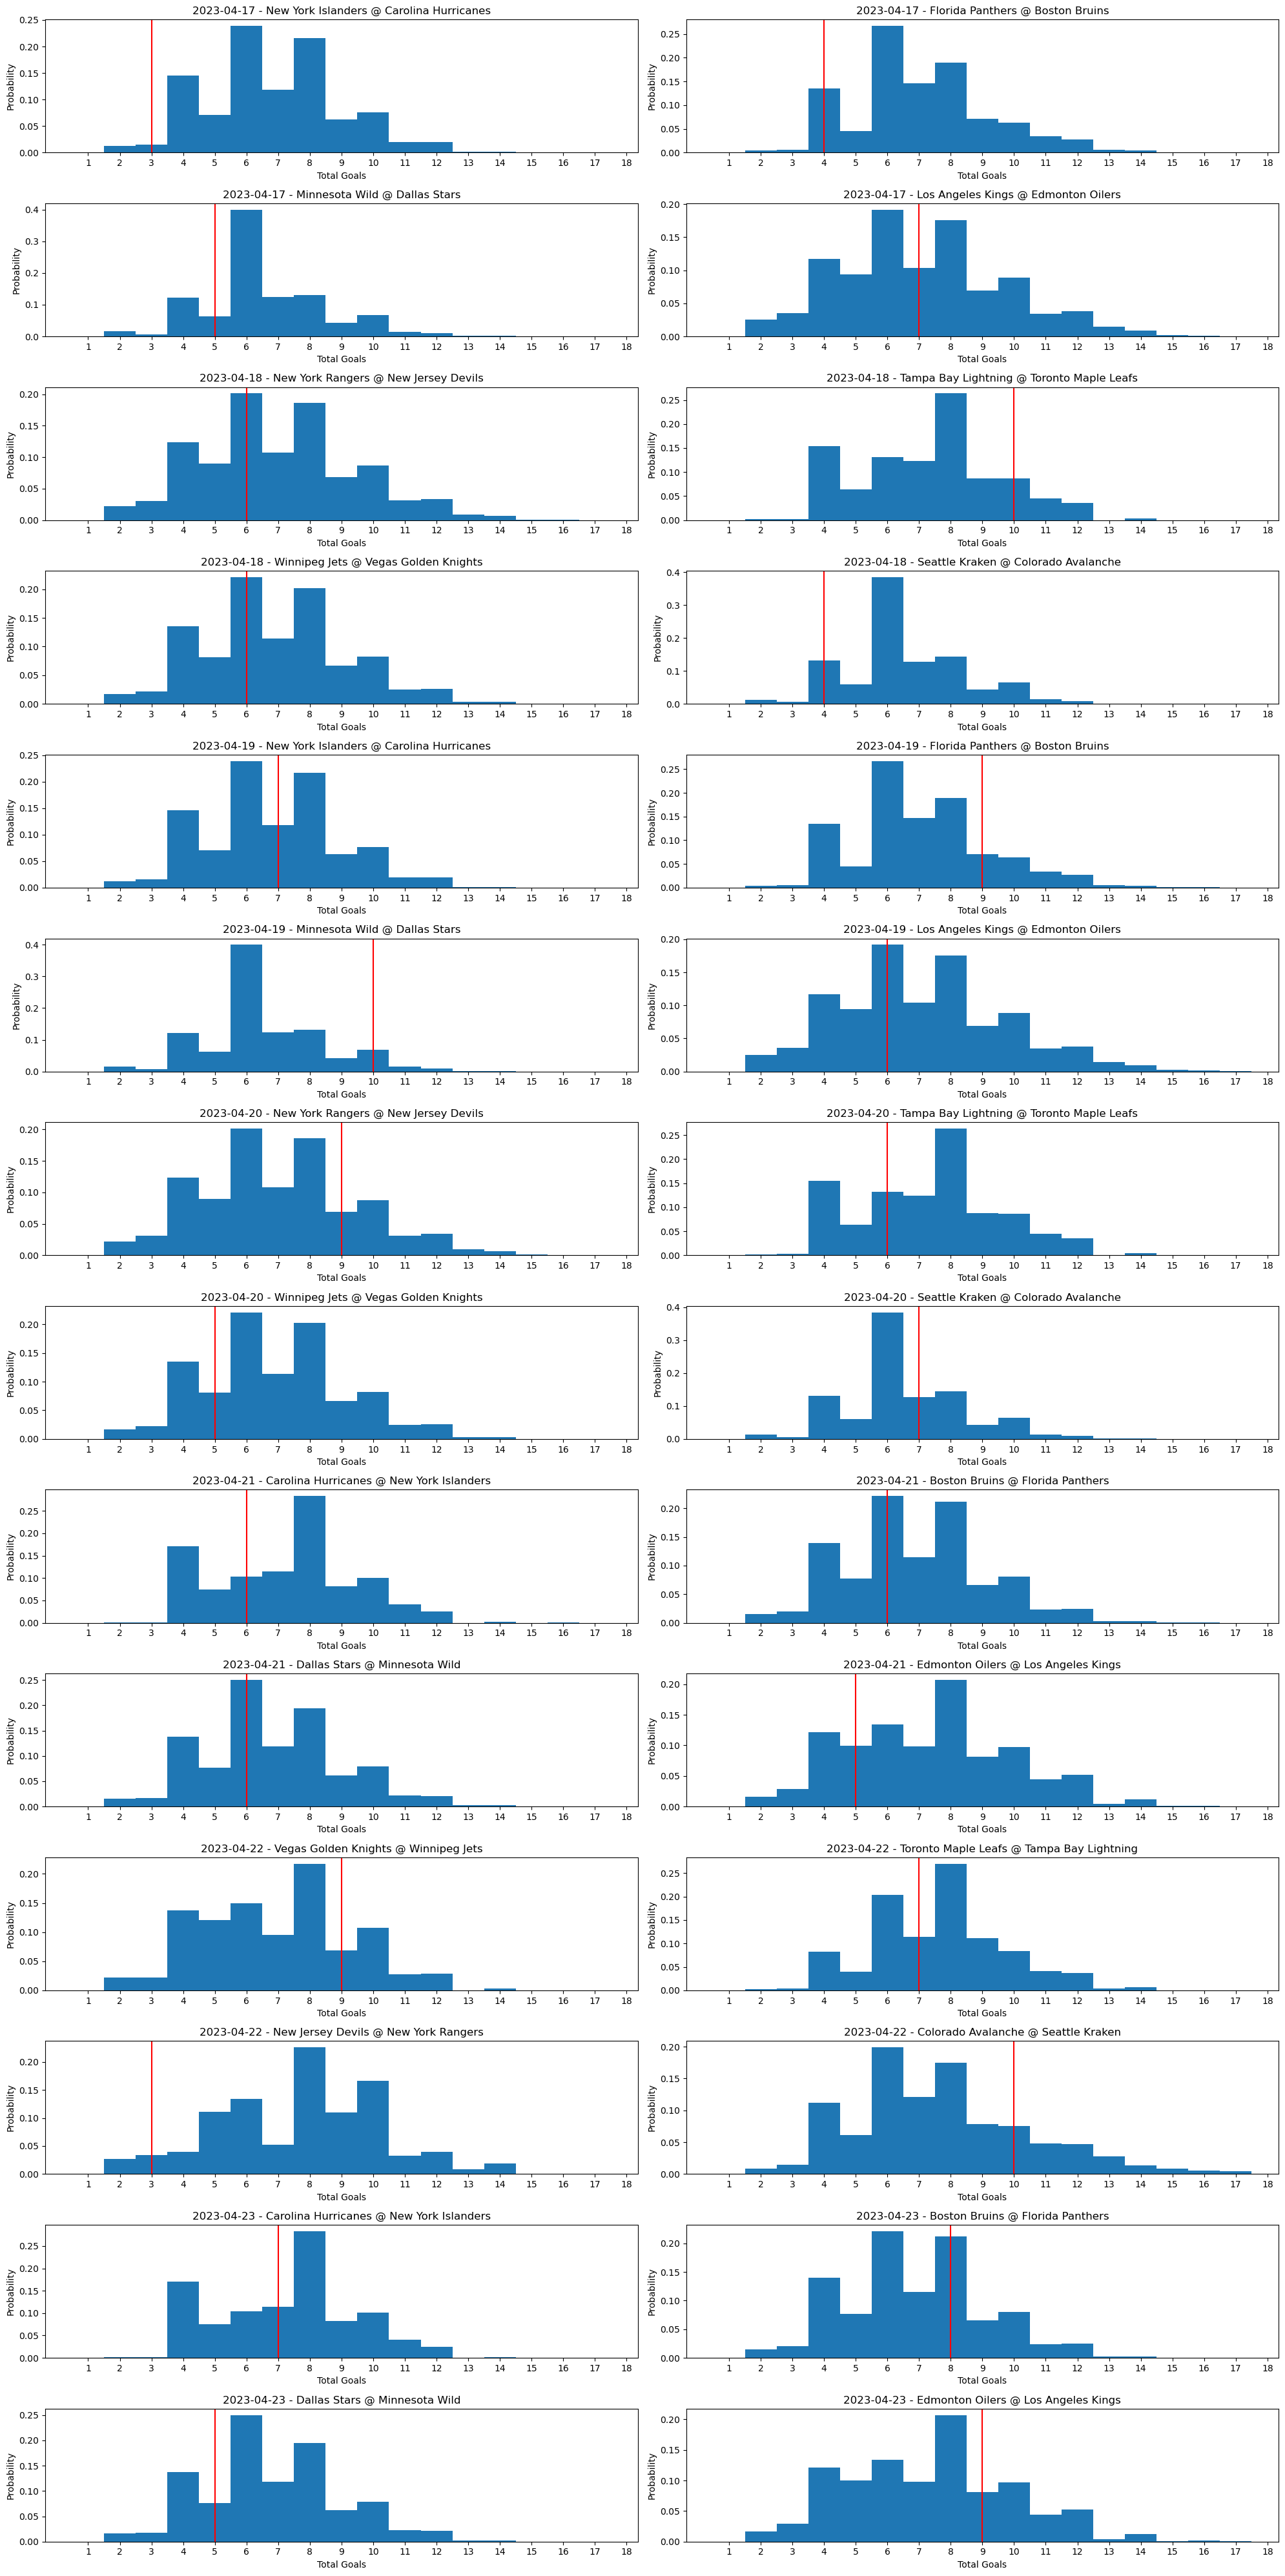

In [227]:
fig, ax = plt.subplots(14,2, figsize=(20,40))

for i in range(len(predicted_goals)):
    goals = range(1,len(predicted_goals[i])+1)
    preds = predicted_goals[i]
    goal_vals = dict(zip(goals, preds))
    
    date = pd.to_datetime(early_2023_test_data['Timestamp'][i], unit='s').strftime('%Y-%m-%d')
    game = f"{date} - {early_2023_test_data['Visitor'][i]} @ {early_2023_test_data['Home'][i]}"
    
    row, col = divmod(i, 2)  
    ax[row, col].hist(list(goal_vals.keys()), bins=goals, weights=list(goal_vals.values()), align='left')
    ax[row, col].axvline(x=early_2023_test_data['total_goals'][i], color='r')
    ax[row, col].set_xticks(goals)
    ax[row,col].set_title(game)
    ax[row,col].set_xlabel('Total Goals')
    ax[row,col].set_ylabel('Probability')

fig.tight_layout()

How often is the actual score in the top 3 predicted scores?

In [231]:
goals = range(1,19)
num_correct = 0

for i in range(len(predicted_goals)):

    preds = predicted_goals[i]
    predictions = dict(zip(goals,preds))
    largest_indices = np.argpartition(preds, -3)[-3:]
    largest_keys = [goals[i] for i in largest_indices]

    actual_goals = early_2023_test_data['total_goals'][i]
    
    if actual_goals in largest_keys:
        num_correct += 1

print(f"The actual score is within the top 3 estimates {num_correct/len(predicted_goals)*100}% of the time")

The actual score is within the top 3 estimates 50.0% of the time


In [248]:
def test_model(neurons):
    """
    Test a model with 3 layers of given size on available 2023 playoff data.
    Returns an average 5 models per layer size as cross-validation.
    """
    def create_model(neurons):
        y, X = patsy.dmatrices("total_goals ~ Timestamp + C(Visitor) + C(Home) + C(playoffs)", 
                       nhl_subset, return_type='matrix')
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)

        model = Sequential()
        model.add(Dense(neurons, input_dim=X.shape[1], activation='relu'))
        model.add(Dense(neurons, activation='relu'))
        model.add(Dense(neurons, activation='relu'))
        model.add(Dense(np.max(y)+1, activation='softmax'))

        model.compile(loss='categorical_crossentropy', optimizer='adam')
        model.fit(X_scaled, keras.utils.to_categorical(y), epochs=100, batch_size=32, verbose=0)
        
        return model
    
    model_1 = create_model(neurons)
    model_2 = create_model(neurons)
    model_3 = create_model(neurons)
    model_4 = create_model(neurons)
    model_5 = create_model(neurons)
    
    def predict_goals(model):
        y, X = patsy.dmatrices("total_goals ~ Timestamp + C(Visitor) + C(Home) + C(playoffs)", 
                       combined_old_new_data, return_type='matrix')

        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X, verbose=0)

        new_data = X_scaled[-28:,:]

        predicted_goals = model.predict(new_data)
        return predicted_goals
    
    
    predicted_goals_1 = predict_goals(model_1)
    predicted_goals_2 = predict_goals(model_2)
    predicted_goals_3 = predict_goals(model_3)
    predicted_goals_4 = predict_goals(model_4)
    predicted_goals_5 = predict_goals(model_5)
    
    def check_accuracy(predicted_goals):
        goals = range(1,19)
        num_correct = 0

        for i in range(len(predicted_goals)):

            preds = predicted_goals[i]
            predictions = dict(zip(goals,preds))
            largest_indices = np.argpartition(preds, -3)[-3:]
            largest_keys = [goals[i] for i in largest_indices]

            actual_goals = early_2023_test_data['total_goals'][i]

            if actual_goals in largest_keys:
                num_correct += 1
                
        return num_correct/len(predicted_goals)*100

        
    acc_1 = check_accuracy(predicted_goals_1)
    acc_2 = check_accuracy(predicted_goals_2)
    acc_3 = check_accuracy(predicted_goals_3)
    acc_4 = check_accuracy(predicted_goals_4)
    acc_5 = check_accuracy(predicted_goals_5)
    
    avg_acc = np.round((acc_1+acc_2+acc_3+acc_4+acc_5)/5)
    
    print(f"With {neurons} neurons the actual score is within the top 3 estimates {avg_acc}% of the time")

In [249]:
neurons = [1,2,5,10,15]

for n in neurons:
    test_model(n)

1/1 [==============================] - 0s 49ms/step
35.714285714285715
With 1 neurons the actual score is within the top 3 estimates 36.0% of the time
1/1 [==============================] - 0s 54ms/step
35.714285714285715
With 2 neurons the actual score is within the top 3 estimates 36.0% of the time
1/1 [==============================] - 0s 52ms/step
46.42857142857143
With 5 neurons the actual score is within the top 3 estimates 40.0% of the time
1/1 [==============================] - 0s 57ms/step
39.285714285714285
With 10 neurons the actual score is within the top 3 estimates 40.0% of the time
1/1 [==============================] - 0s 58ms/step
32.142857142857146
With 15 neurons the actual score is within the top 3 estimates 35.0% of the time


In [272]:
epochs = [100]

for n in epochs:
    test_model(n)

TypeError: Unexpected keyword argument passed to optimizer: nesterov_momentum. Allowed kwargs are {'global_clipnorm', 'clipnorm', 'lr', 'clipvalue', 'decay'}.